## Posteriori Balancing Notebook

---

In this notebook we will focus on posteriori data balancing. This means that we focus on the extracted features, and we try to balance the data by using undersampling and oversampling techniques.

1. [Load Data](#Load-Data)
2. [Feature Distribution](#Feature-Distribution)
3. [Feature Balancing](#Feature-Balancing)


In [1]:
# import all the functions
import sys
sys.path.append('../')
from utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import importlib
importlib.reload(sys.modules['utils'])

<module 'utils' from '/home/ligari/github/unipv/advanced-biomedical-project/notebooks/balancing/../utils.py'>

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

# -------- tqdm DARK THEME --------

#### 1. Load Data <a id='Load-Data'></a>


In [3]:
# properties of the data



# paths to the features and the labels
FEATURES_RAW_DIR = "../../features/raw/"

#FEATURES_PRIORI_BAL_DIR = "../../features/balanced/priori/"
FEATURES_PRIORI_BAL_DIR = FEATURES_RAW_DIR


DIRS = [FEATURES_RAW_DIR, FEATURES_PRIORI_BAL_DIR]

FEATURES_POSTERIORI_BAL_DIR = "../../features/balanced/posteriori/"
#FEATURES_POSTERIORI_BAL_DIR = "../../features/balanced/both/"

num_feats = {
    "30 MFCC": "30mfcc",
    "12  Chroma": "12chroma",
    "70 CQT": "70cqt",
    "40 RMS": "41rms",
    "40 Zero Crossing Rates": "41zcr",
    "40 Spectral Centroid": "41sc",
    "60 Spectral Bandwidth": "61sb",
    "40 Spectral Rolloff": "41sr",
}

target_size = 300

#### 2. Feature Distribution <a id='Feature-Distribution'></a>


artifacts features   -   Label: 0.0
Max: 167.3822479248047, Min: -1131.36962890625, Mean: -13.406277656555176, Std: 75.21491241455078      -       Shape: (1199, 30)

extrahls features   -   Label: 1.0
Max: 148.4971923828125, Min: -697.9547729492188, Mean: -14.326969146728516, Std: 84.45529174804688      -       Shape: (124, 30)

murmurs features   -   Label: 2.0
Max: 192.76806640625, Min: -565.3004150390625, Mean: -4.308747291564941, Std: 61.683414459228516      -       Shape: (1149, 30)

normals features   -   Label: 3.0
Max: 165.34193420410156, Min: -601.60205078125, Mean: -4.142438888549805, Std: 53.22137451171875      -       Shape: (2161, 30)

extrastoles features   -   Label: 4.0
Max: 148.1114501953125, Min: -309.2425537109375, Mean: -2.4291136264801025, Std: 47.309688568115234      -       Shape: (247, 30)



artifacts features   -   Label: 0.0
Max: 167.3822479248047, Min: -1131.36962890625, Mean: -13.406277656555176, Std: 75.21491241455078      -       Shape: (1199, 30)

extrah

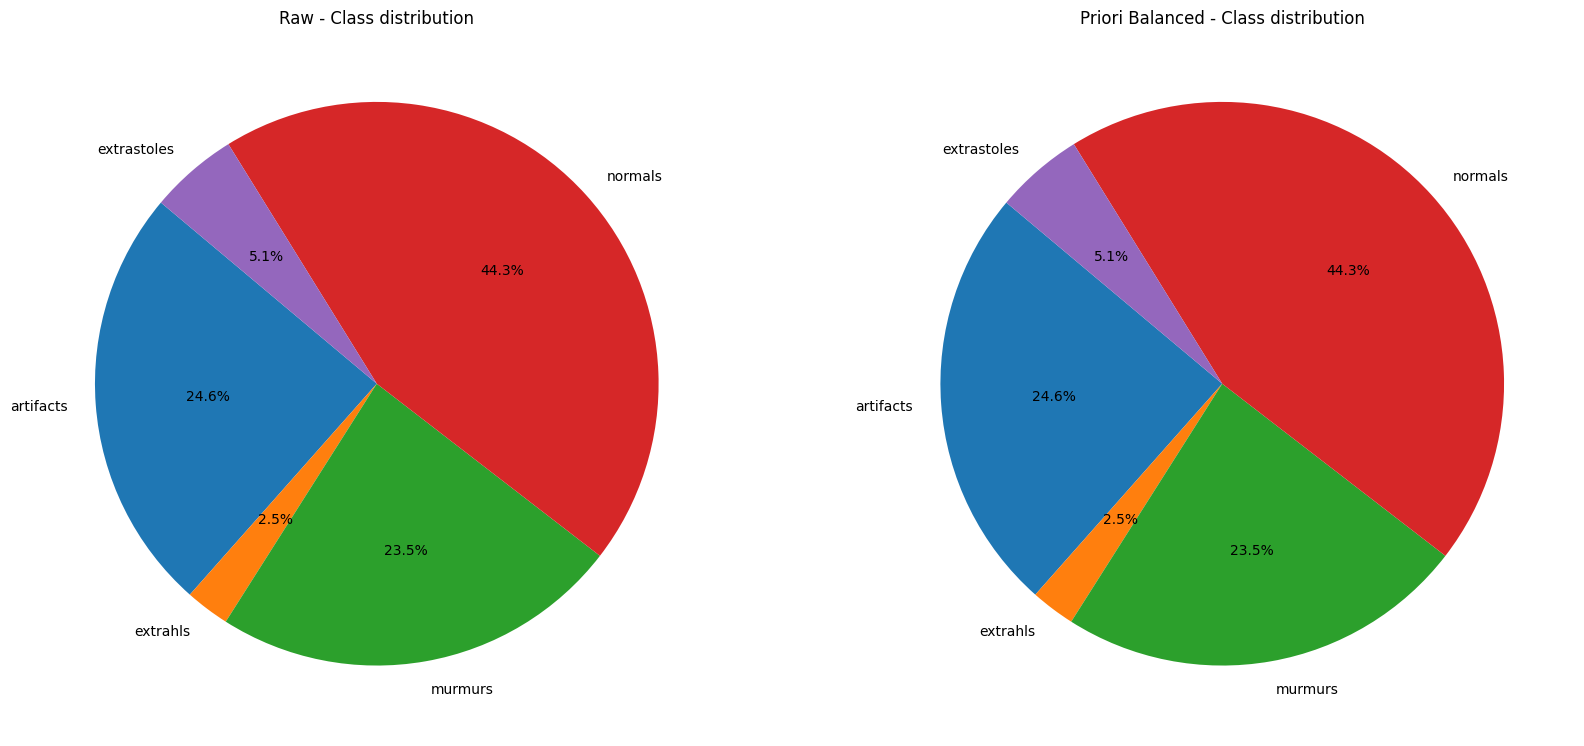

In [4]:
# path for pie chart. Just one one the features file is sufficient since they are all the same in term of class distribution
extraction_interval = 1
sample_rate = 4000
n_mfcc = 30
NAME = f"full_data_{extraction_interval}s_{sample_rate}hz_{n_mfcc}mfcc.npy"

# pie charts
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
titles = ["Raw", "Priori Balanced"]

for i, DIR in enumerate(DIRS):
    full_data = np.load(DIR + NAME, allow_pickle=True).item()
    class_names = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]
    shapes = []
    name_labels = {}

    for name in class_names:
        features = full_data[name]["X"]
        label = full_data[name]["y"][0]
        name_labels[name] = label
        max = features.max()
        min = features.min()
        mean = features.mean()
        std = features.std()
        print(f"{name} features   -   Label: {label}")
        print(
            f"Max: {max}, Min: {min}, Mean: {mean}, Std: {std}      -       Shape: {features.shape}\n"
        )
        shapes.append(features.shape[0])

    print("\n")
    title = titles[i]
    axs[i].pie(shapes, labels=name_labels.keys(), autopct="%1.1f%%", startangle=140)
    axs[i].set_title(f"{title} - Class distribution")

#### 3. Feature Balancing <a id='Feature-Balancing'></a>


To address the problem of class imbalance, we have different options:

- **Undersampling**: randomly remove samples from the majority class. However the high difference in the number of samples between classes may lead to a loss of information. This approach may be viable, reducing the frame window size, to enlarge the number of samples in the minority class. We skip this approach for now.
- **Classic Oversampling**: randomly duplicate samples from the minority class. This approach may lead to overfitting, as the model may learn the same samples multiple times. We skip this approach for now.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: generate synthetic samples from the minority class. This approach may be more robust than the classic oversampling, as it generates new samples based on the existing ones. We will use this approach to balance the classes.


In [5]:
for name,num_feat in num_feats.items():
    print(f"Processing 4000hz_{num_feat}")
        
    # load all the priori balanced features
    full_data_tmp = []
    s = 0

    # Load the data
    FEATURES_NAME = f"full_data_{extraction_interval}s_{sample_rate}hz_{num_feat}.npy"
    full_data = np.load(FEATURES_PRIORI_BAL_DIR + FEATURES_NAME, allow_pickle=True).item()
    
    names = ["artifacts", "extrahls", "murmurs", "normals", "extrastoles"]

    # ------- OLD VERSION -------
    # for name in os.listdir(FEATURES_PRIORI_BAL_DIR):
    #     if name == NAME:
    #         continue
    #     features = np.load(FEATURES_PRIORI_BAL_DIR + name)['X']
    #     label = np.load(FEATURES_PRIORI_BAL_DIR + name)['y']
    #     filename = np.load(FEATURES_PRIORI_BAL_DIR + name)['filename']
    #     array = np.hstack((features, label.reshape(-1, 1), filename.reshape(-1, 1)))
    #     full_data_tmp.append(array)
    #     s += features.shape[0]
    # --------------------------

    for name in names:
        features = full_data[name]["X"]
        label = full_data[name]["y"]
        filename = full_data[name]["filename"]
        array = np.hstack((features, label.reshape(-1, 1), filename.reshape(-1, 1)))
        full_data_tmp.append(array)
        s += features.shape[0]

    # create a unique array with all the features
    full_data = np.vstack(full_data_tmp)

    # divide the data into features and labels
    X = full_data[:, :-2]
    y = full_data[:, -2]
    filename = full_data[:, -1]

    # split the data into training and testing
    X_train, X_test, y_train, y_test, filename_train, filename_test = train_test_split(
        X, y, filename, test_size=0.2, random_state=42, stratify=y
    )

    # attach filename and label to the features
    train = np.hstack((X_train, y_train.reshape(-1, 1), filename_train.reshape(-1, 1)))
    test = np.hstack((X_test, y_test.reshape(-1, 1), filename_test.reshape(-1, 1)))

    # class distribution before balancing
    unique_classes, class_counts = np.unique(train[:, -2], return_counts=True)
    print(f"Class distribution before balancing: {dict(zip(unique_classes, class_counts))}")

    # balance the training data
    train_balanced = rebalance_data(train, target_size=target_size, random_seed=42)

    # check the train_balanced data
    print(f"Original training data shape: {train.shape}")
    print(f"Balanced training data shape: {train_balanced.shape}")
    
    # create a dictionary to save the data
    train_bal = {}
    train_bal["X"] = train_balanced[:, :-2]
    train_bal["y"] = train_balanced[:, -2]
    train_bal["filename"] = train_balanced[:, -1]

    train_unb = {}
    train_unb["X"] = train[:, :-2]
    train_unb["y"] = train[:, -2]
    train_unb["filename"] = train[:, -1]

    test_dict = {}
    test_dict["X"] = test[:, :-2]
    test_dict["y"] = test[:, -2]
    test_dict["filename"] = test[:, -1]

    # aggregate the dictionary into another dictionary
    full_data = {}
    full_data["train_unb"] = train_unb
    full_data["train_bal"] = train_bal
    full_data["test"] = test_dict

    # save the data
    NAME = "full_data.npy"
    np.save(
        FEATURES_POSTERIORI_BAL_DIR
        + f"full_data_{extraction_interval}s_{sample_rate}hz_{num_feat}.npy",
        full_data,
    )

Processing 4000hz_30mfcc
Class distribution before balancing: {0.0: 959, 1.0: 99, 2.0: 919, 3.0: 1729, 4.0: 198}
Original training data shape: (3904, 32)
Balanced training data shape: (1500, 32)
Processing 4000hz_12chroma
Class distribution before balancing: {0.0: 959, 1.0: 99, 2.0: 919, 3.0: 1729, 4.0: 198}
Original training data shape: (3904, 14)
Balanced training data shape: (1500, 14)
Processing 4000hz_70cqt
Class distribution before balancing: {0.0: 959, 1.0: 99, 2.0: 919, 3.0: 1729, 4.0: 198}
Original training data shape: (3904, 72)
Balanced training data shape: (1500, 72)
Processing 4000hz_41rms
Class distribution before balancing: {0.0: 959, 1.0: 99, 2.0: 919, 3.0: 1729, 4.0: 198}
Original training data shape: (3904, 43)
Balanced training data shape: (1500, 43)
Processing 4000hz_41zcr
Class distribution before balancing: {0.0: 959, 1.0: 99, 2.0: 919, 3.0: 1729, 4.0: 198}
Original training data shape: (3904, 43)
Balanced training data shape: (1500, 43)
Processing 4000hz_41sc
Cla

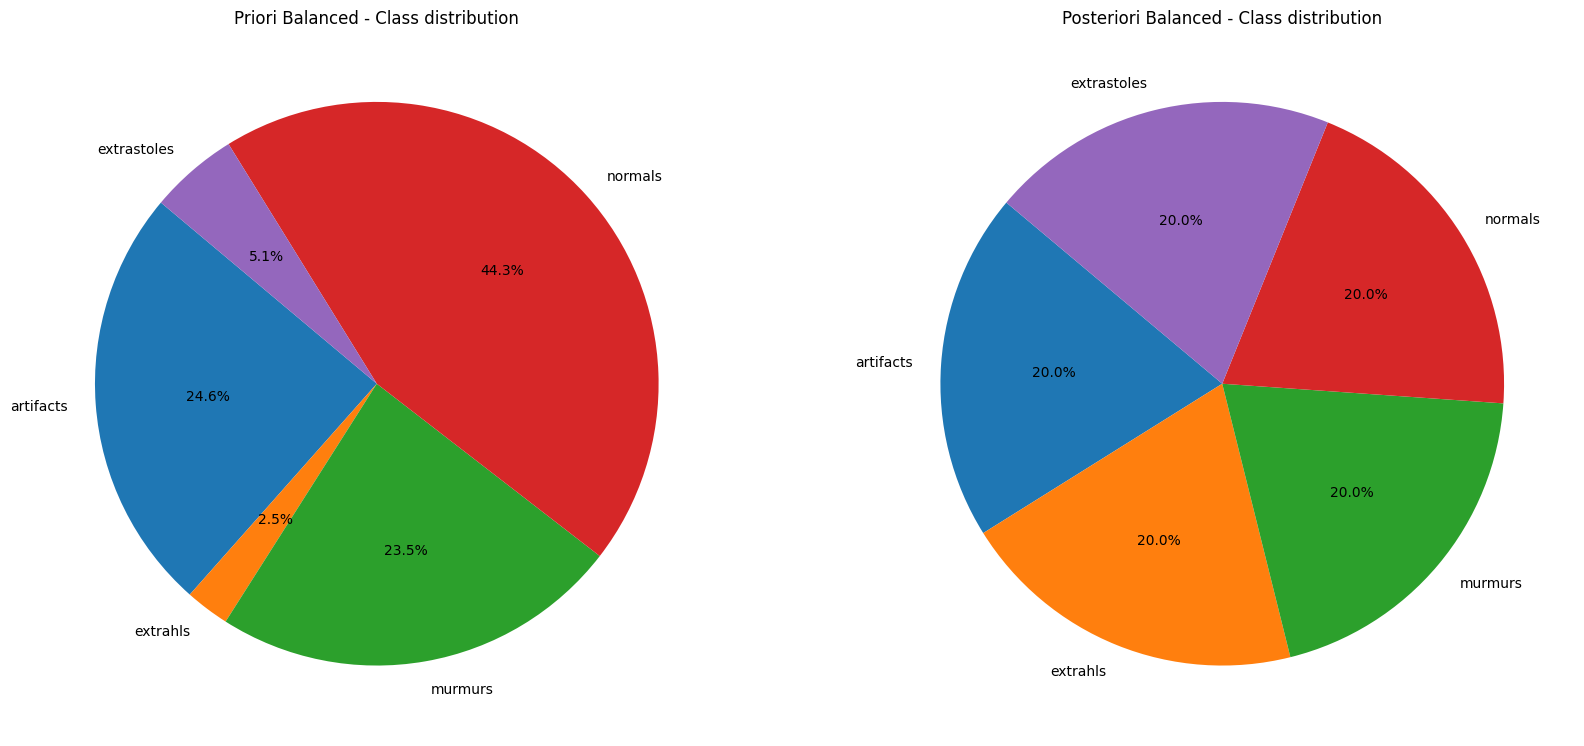

In [6]:
# revert the name_labels dictionary
name_labels_reverse = {v: k for k, v in name_labels.items()}
labels = []
unique_classes = np.unique(train[:, -2])
for class_ in unique_classes:
    labels.append(name_labels_reverse[class_])

# pie chart priori vs posteriori balanced
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
titles = ["Priori Balanced", "Posteriori Balanced"]

for i, data in enumerate([train, train_balanced]):
    unique_classes, class_counts = np.unique(data[:, -2], return_counts=True)
    title = titles[i]
    axs[i].pie(class_counts, labels=labels, autopct="%1.1f%%", startangle=140)
    axs[i].set_title(f"{title} - Class distribution")

In [7]:
# load the data
full_data = np.load(
    FEATURES_POSTERIORI_BAL_DIR + f"full_data_{extraction_interval}s_{sample_rate}hz_{num_feat}.npy",
    allow_pickle=True,
).item()

# check the data
print(full_data.keys())
print(full_data["train_unb"].keys())
print(full_data["train_bal"].keys())
print(full_data["test"].keys())

# check the data shape
print(full_data["train_unb"]["X"].shape)
print(full_data["train_bal"]["X"].shape)
print(full_data["test"]["X"].shape)

# check the class distribution
unique_classes, class_counts = np.unique(full_data["train_unb"]["y"], return_counts=True)
print(f"Train unb class distribution: {dict(zip(unique_classes, class_counts))}")

unique_classes, class_counts = np.unique(full_data["train_bal"]["y"], return_counts=True)
print(f"Train bal class distribution: {dict(zip(unique_classes, class_counts))}")

unique_classes, class_counts = np.unique(full_data["test"]["y"], return_counts=True)
print(f"Test class distribution: {dict(zip(unique_classes, class_counts))}")

dict_keys(['train_unb', 'train_bal', 'test'])
dict_keys(['X', 'y', 'filename'])
dict_keys(['X', 'y', 'filename'])
dict_keys(['X', 'y', 'filename'])
(3904, 41)
(1500, 41)
(976, 41)
Train unb class distribution: {0.0: 959, 1.0: 99, 2.0: 919, 3.0: 1729, 4.0: 198}
Train bal class distribution: {0.0: 300, 1.0: 300, 2.0: 300, 3.0: 300, 4.0: 300}
Test class distribution: {0.0: 240, 1.0: 25, 2.0: 230, 3.0: 432, 4.0: 49}
